# Quantitative Model Training Notebook
This Notebook is designed to determine the empirical parameters needed to estimate concentration ratios from Raman intensity ratios. It requires given pre-processed input spectra generated by the OSTRI_Raman-Processing Notebook, which must be carefully baselined to ensure generation of an accurate model. The model uses bootstrapping to estimate fitting and prediction errors, which requires 10+ spectra per sample.

Once the model has fitted the data and generated best-fit values for empirical parameters FXJ, FXB, and JA, these parameters can be used to predict concentration ratios from intensity ratios using the OSTRI_Model-Testing Notebook.

In [ ]:
# ==================================================
# define where your data is, and what files to import

# list directories for input data, figures and output files
Data_dir = './output/'
Fig_dir = './new figures/'
Out_dir = './output/'
Ref_dir = './data/Standards/'

Technique = 'Raman'         # 'Raman' or 'FTIR'

# filter data import by sample / subsample
Instrument = 'MOBIUS'           # name of Instrument
Mixture = 'dATP_Na2SO4_H2O'     # name of mixture series, please only run one at a time
FileType = 'all-spectra-baselined'

# list of filenames not to import
Do_Not_Import = []

Components = Mixture.split("_")

# specify which components to use as A and B
Evaluation_Components = ['dTTP', 'Na2SO4']

# specify which intensity values to use for each component
Intensity_Keys = {
    'dATP': {'Raw': [1310], 'Fitting': [1310]},
    'dCTP': {'Raw': [1510], 'Fitting': [1510]},
    'dGTP': {'Raw': [1460], 'Fitting': [1460]},
    'dTTP': {'Raw': [1350], 'Fitting': [1635]},
    'Na2SO4': {'Raw': [945], 'Fitting': [945]},
    'H2O': {'Raw': [3400], 'Fitting': [3400]}
}

# Define method for evaluating intensities
Intensity_Method = 'Raw'        # method for measuring intensity, 'Raw', 'Fitting', or 'Deconvolution'
Fitting_property = 'amplitude'  # fitted peak property to use as intensity, 'amplitude' or 'area'

# Specify whether to bootstrap resample data (needed to estimate errors, requires 10+ spectra per sample)
Bootstrap = True
N_Bootstraps = 1000

Laser_Wavelength = '248'        # wavelength in nm, as str

In [2]:
# ==================================================
# this section imports necessary python modules and looks for available data files

import os
import math
import glob
import datetime
import numpy as np
import pandas as pd
import lmfit as lmfit
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
from itertools import combinations
from itertools import combinations_with_replacement

# import VibSpec module functions
from OSTRI_functions import *

"""
# ==================================================
# FILE SEARCH
# - this section searches for spectrum files that match the specified settings
# ==================================================
"""

print("SEARCHING FOR SPECTRUM DATA FILES...")

# find files
#   - currently requires data files to be named and organised as follows:
# Data_dir/{Sample}/{Measurement_Date}/{Measurement_ID}_{Sample}_{Subsample}_{Measurement Parameters}.txt
text = "%s%s/%s_*/*_%s.csv" % (Data_dir, Mixture, Instrument, FileType)
print(text)
spec_dirs = sorted(glob.glob(text))

# for each file, get components and concentrations for sorting
mixtures = []
conc_ratios = []
for file in spec_dirs:
    while True:
        try:
            temp = file.split("/")[-1][:-4].split("_")[0:-1]
            components = {}
            for item in temp:
                comp, val = item.split("-")
                for i, c in enumerate(val):
                    if c not in '0123456789.':
                        conc = float(val[:i])
                        unit = val[i:]
                        break
                # standardise units to ppm
                if unit == 'wt':
                    conc_ppm = conc * 1000000. / 100.
                elif unit == 'mM':
                    conc_ppm = conc * 1000000. / 55510.
                components[comp] = conc_ppm
            conc_ratio = np.float64(components[Components[0]]) / np.float64(components[Components[1]])
            mixtures.append("_".join(list(components.keys())))
            conc_ratios.append(conc_ratio)
            break
        except Exception as e:
            print("something went wrong! Exception:", e)
            break
            
# sort by mixture and concentration ratio
sort = np.lexsort((conc_ratios, mixtures))
spec_dirs = np.asarray(spec_dirs)[sort]

print("data files found:", len(spec_dirs))
for file in spec_dirs:
    print("    ", file.split("/")[-1])
    comps = file.split("/")[-1][:-4].split("_")[0:-1]
    for comp in comps:
        comp, conc = comp.split("-")
        print("        %10s: %10s" % (comp, conc))

SEARCHING FOR SPECTRUM DATA FILES...
./output/dTTP_Na2SO4_H2O/MOBIUS_*/*_all-spectra-baselined.csv
data files found: 12
     dTTP-0.01mM_Na2SO4-99.99mM_H2O-55510mM_all-spectra-baselined.csv
              dTTP:     0.01mM
            Na2SO4:    99.99mM
               H2O:    55510mM
     dTTP-0.025mM_Na2SO4-99.975mM_H2O-55510mM_all-spectra-baselined.csv
              dTTP:    0.025mM
            Na2SO4:   99.975mM
               H2O:    55510mM
     dTTP-0.05mM_Na2SO4-99.95mM_H2O-55510mM_all-spectra-baselined.csv
              dTTP:     0.05mM
            Na2SO4:    99.95mM
               H2O:    55510mM
     dTTP-0.075mM_Na2SO4-99.925mM_H2O-55510mM_all-spectra-baselined.csv
              dTTP:    0.075mM
            Na2SO4:   99.925mM
               H2O:    55510mM
     dTTP-0.1mM_Na2SO4-99.9mM_H2O-55510mM_all-spectra-baselined.csv
              dTTP:      0.1mM
            Na2SO4:     99.9mM
               H2O:    55510mM
     dTTP-0.25mM_Na2SO4-99.75mM_H2O-55510mM_all-spectra-baselin

# Data import

- this section actually imports data files and their corresponding metadata
- metadata can be in a separate CSV file with the same name plus '\_metadata', or can be extracted from the data file's name
- measurements are imported file by file, and added sequentially to the 'data' dict
- to access a specific measurement, you call data\[measurement ID\]\[key\], where 'key' is the type of data you want from it

IMPORTING DATA...

importing dTTP-0.01mM_Na2SO4-99.99mM_H2O-55510mM_all-spectra-baselined
MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
['dTTP-0.01mM', 'Na2SO4-99.99mM', 'H2O-55510mM']
              dTTP: 1.0E-02 mM - 1.8E-01 ppm
            Na2SO4: 1.0E+02 mM - 1.8E+03 ppm
               H2O: 5.6E+04 mM - 1.0E+06 ppm
evaluated conc. ratio: 1.0E-04 dTTP/Na2SO4
    spec array: (27, 1024)
    spectral map, 25 points
              shift: (1024,)
          intensity: (1024, 25)
        shift range: 573 - 4252 cm-1
         inf check: 0/1024
         nan check: 0/1024
        zero check: 0/1024
    imported successfully!

importing dTTP-0.025mM_Na2SO4-99.975mM_H2O-55510mM_all-spectra-baselined
MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
['dTTP-0.025mM', 'Na2SO4-99.975mM', 'H2O-55510mM']
              dTTP: 2.5E-02 mM - 4.5E-01 ppm
            Na2SO4: 1.0E+02 mM - 1.8E+03 ppm
               H2O: 5.6E+04 mM - 1.0E+06 ppm
evaluated conc. ratio: 2.5E-04 dTTP/Na2SO4
    spec array: (27, 1024)
    spectr

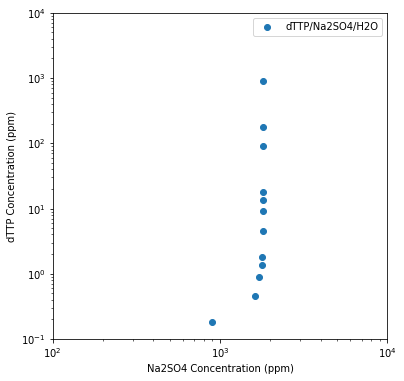


laser wavelengths in dataset:
     248 nm


In [3]:
print("IMPORTING DATA...")

# print debug messages?
debug = True

# set up data storage dictionary
data = {}

# ==================================================
# each measurement imported will be added to this dictionary as a Measurement object
# To access a particular measurement, use data[measurement ID]

# for each detected file
count = 0
for spec_dir in spec_dirs:
    while True:
        try:
            filename = spec_dir.split("/")[-1][:-4]
            title = file.split("/")[-2]
            ID = count
            if filename in Do_Not_Import:
                print()
                print(" measurement %s is in Do_Not_Import list, skipping" % filename)
                break
            else:
                print()
                print("importing %s" % filename)
                print(title)
                # extract sample/measurement metadata
                instrument = filename.split("_")[0]
                temp = filename.split("_")[:-1]
                print(temp)
                components = {}
                for item in temp:
                    comp, val = item.split("-")
                    for i, c in enumerate(val):
                        if c not in '0123456789.':
                            conc = float(val[:i])
                            unit = val[i:]
                            break
                    # standardise units to ppm
                    if unit == 'wt':
                        conc_ppm = conc * 1000000. / 100.
                    elif unit == 'mM':
                        conc_ppm = conc * 1000000. / 55510.
                    components[comp] = conc_ppm
                    print("        %10s: %0.1E %s - %0.1E ppm" % (comp, conc, unit, conc_ppm))
                conc_ratio = components[Components[0]]/components[Components[1]]
                print("evaluated conc. ratio: %0.1E %s/%s" % (conc_ratio, Components[0], Components[1]))
                # import spectrum file (assumes pre-processed OSTRI data file format)
                spec = np.genfromtxt(spec_dir, delimiter=',', skip_header=1).transpose()
                print("    spec array:", np.shape(spec))
                xy_coords = np.asarray([[0],[0]])
                points = np.size(spec, axis=0) - 2
                if points > 1:
                    spec_type = 'map'
                    print("    spectral map, %s points" % (points))
                else:
                    spec_type = 'point'
                    print("    single point measurement")
                wavelength = spec[0]
                raman_shift = spec[1]
                y = spec[2:]
                sort = np.argsort(raman_shift)
                raman_shift = raman_shift[sort]
                y = y.transpose()[sort,:]
                        
                infcheck = np.any(np.isinf(y), axis=1)
                nancheck = np.any(np.isnan(y), axis=1)
                zerocheck = np.any(y == 0, axis=1)
                check = np.logical_or.reduce((infcheck, nancheck, zerocheck))
                if debug == True:
                    print("              shift:", np.shape(raman_shift))
                    print("          intensity:", np.shape(y))
                    print("        shift range: %0.f - %0.f cm-1" % (np.nanmin(raman_shift), np.nanmax(raman_shift)))
                    print("         inf check: %0.f/%0.f" % (np.count_nonzero(infcheck),
                                                               np.size(infcheck)))
                    print("         nan check: %0.f/%0.f" % (np.count_nonzero(nancheck),
                                                               np.size(nancheck)))
                    print("        zero check: %0.f/%0.f" % (np.count_nonzero(zerocheck),
                                                               np.size(zerocheck)))
                if np.count_nonzero(check) > 0.1 * np.size(check):
                    raise Exception("%0.f%% of spectrum data is 0/nan/inf! Cannot import!" % (100*np.count_nonzero(check)/np.size(check)))
                # get average spectrum (for single points, just use spec)
                y_av = np.mean(y, axis=0)
                # define name for output folder structure
                output_folder = '%s/%s/' % ("_".join(components.keys()), title)
                # create Measurement instance from imported data
                data[str(ID)] = Measurement(
                    ID=str(ID),
                    title=title,
                    filename=filename,
                    sample="/".join(Mixture.split("_")),
                    components=components,
                    conc_ratio=conc_ratio,
                    x=raman_shift[~check],
                    y=y[~check],
                    spec_type=spec_type,
                    points=points,
                    ykey='y',
                    technique='Raman',
                    instrument=instrument,
                    laser_wavelength=Laser_Wavelength,
                    generate_average=True,
                    x_coords=xy_coords[0],
                    y_coords=xy_coords[1],
                    Fig_dir = Fig_dir,
                    Out_dir = Out_dir,
                    output_folder = output_folder
                )
                
                count += 1
                print("    imported successfully!")
                break
        except Exception as e:
            print("    something went wrong! Exception:", e)
            break
        
print()
print("%s/%s files imported" % (len(data.keys()), len(spec_dirs)))

# ==================================================
# update list of Spec IDs to only include imported spectra
Spec_IDs = list(data.keys())

# ==================================================
# report how many spectra were imported for each mixture, sample

mixtures = np.unique([data[ID]['sample'] for ID in Spec_IDs])
print()
print("mixtures in dataset:")
plt.figure(figsize=(6,6))
for i1, mixture in enumerate(mixtures):
    print("    ", mixture)
    print("        samples:", len([data[ID]['sample'] == mixture for ID in Spec_IDs]))
    print("%16s: %15s:" % ("concs", "spectra"))
    A_concs = np.sort([data[ID]['components'][Components[0]] for ID in Spec_IDs])
    B_concs = np.sort([data[ID]['components'][Components[1]] for ID in Spec_IDs])
    for i2, ID in enumerate(Spec_IDs):
        print("%20.1E ppm       %3d" % (A_concs[i2], data[ID].points))
    plt.scatter(B_concs, A_concs, label=mixture)
x_min = 10**np.floor(0.9*np.log10(np.nanmin(B_concs)))
x_max = 10**np.ceil(1.1*np.log10(np.nanmax(B_concs)))
y_min = 10**np.floor(0.9*np.log10(np.nanmin(A_concs)))
y_max = 10**np.ceil(1.1*np.log10(np.nanmax(A_concs)))
plt.xscale('log')
plt.xlim(x_min, x_max)
plt.yscale("log")
plt.ylim(y_min, y_max)
plt.xlabel("%s Concentration (ppm)" % Components[1])
plt.ylabel("%s Concentration (ppm)" % Components[0])
plt.legend()
plt.show()

# ==================================================
# report how many distinct laser wavelengths are represented in dataset

lasers = np.unique([measurement.laser_wavelength for ID, measurement in data.items()])
print()
print("laser wavelengths in dataset:")
for laser in lasers:
    print("    ", laser, "nm")

# Get Intensity Values
Uses method specified by Intensity_Method at the start of the NoteBook.

Raw Mode: Returns absolute intensity (in counts) at a specified peak position. Requires the following:
    - positions dict containing component:[peak position] pairs, 1+ positions per component
    
Fitting Mode: Returns absolute intensity (in counts) at a specified peak position. Requires the following:
    - Fitting Array
    - Evaluation Array
    
Deconvolution Mode: Returns absolute intensity (in counts) at a specified peak position. Requires the following:
    - List of 2+ standards to import and use in deconvolution

MEASURING RAW INTENSITIES...

peaks to process: [945, 1350, 1635, 3400]

measurement array lengths found: [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
    max: 25

getting data to plot raman_shift v y_av for MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
 output x,y arrays: (1024,) (1024, 1)

getting data to plot raman_shift v y_av for MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
 output x,y arrays: (1024,) (1024, 1)

getting data to plot raman_shift v y_av for MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
 output x,y arrays: (1024,) (1024, 1)

getting data to plot raman_shift v y_av for MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
 output x,y arrays: (1024,) (1024, 1)

getting data to plot raman_shift v y_av for MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
 output x,y arrays: (1023,) (1023, 1)

getting data to plot raman_shift v y_av for MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
 output x,y arrays: (1023,) (1023, 1)

getting data to plot raman_shift v y_av for MOBIUS_dTTP-50mM_Na2SO4-50mM_H2O-55510mM
 ou

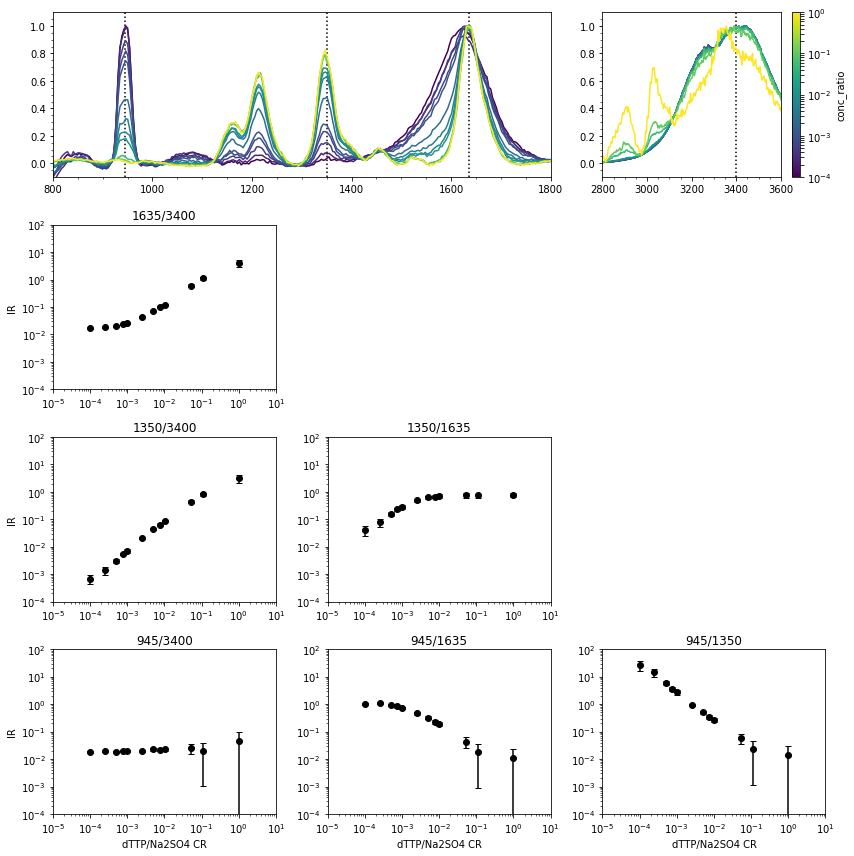


945 intensity array: (12, 25)
1350 intensity array: (12, 25)
1635 intensity array: (12, 25)
3400 intensity array: (12, 25)

end of Raw Mode measurement section!


In [4]:
# print debug messages in viewer?
debug = True

# input parameters for Raw Mode
positions = {
    'dATP': [1310, 1460],
    'dCTP': [1510, 1625],
    'dGTP': [1460, 1560],
    'dTTP': [1350, 1635],
    'Na2SO4': [945],
    'H2O': [3400]
}

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y'

# X range for plotting spectra
x_start, x_end = (800, 1800)

# smooth data before measuring intensity?
smooth = True

# property to use for colour mapping
colour_by = 'conc_ratio'
colour_norm = 'log'

# offset spectra
offset = 0.

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

# create storage array
intensities = []
test_intensities = []

from itertools import combinations

if Intensity_Method != 'Raw':
    print("skipping this section...")
else:
    print("MEASURING RAW INTENSITIES...")
    
    # ==================================================
    # pick peak positions based on components
    peaks = []
    for comp in Components:
        peaks += positions[comp]
    peaks = sorted(peaks)
    print()
    print("peaks to process:", peaks)
    
    # get concentration ratios
    CR = np.asarray([data[ID].conc_ratio for ID in Spec_IDs])
    
    # determine largest measurement array size
    lengths = [data[ID].points for ID in Spec_IDs]
    print()
    print("measurement array lengths found:", lengths)
    print("    max:", max(lengths))
    
    intensities = {str(key): np.full((len(Spec_IDs), max(lengths)), np.nan, dtype=np.float64) for key in peaks}
    
    for i1, ID in enumerate(Spec_IDs):
        # for each measurement
        
        # get spectrum
        x, y = data[ID](x_key, y_key)
        
        if smooth == True:
            y = smooth_spectrum(y, 5, 3)
        
        for peak in peaks:
            # get intensity for this peak
            intensities[str(peak)][i1] = y[np.argmin(np.abs(x - peak))]
    
    # get mean and st.dev. values for plotting
    intensities_av = {key: np.nanmean(temp, axis=1) for key, temp in intensities.items()}
    intensities_std = {key: np.nanstd(temp, axis=1) for key, temp in intensities.items()}
    
    # ==================================================
    # plot results, if required
    if show_plot == True or save_plot == True:
        # create figure
        fig_size = len(peaks)
        plt.figure(figsize=(3*fig_size, 3*(fig_size)))

        # create subplots for spectra
        if 'H2O' in Components:
            hydration = True
            ax1 = plt.subplot2grid((fig_size, fig_size-1), (0,0), colspan=fig_size-2)
            ax2 = plt.subplot2grid((fig_size, fig_size-1), (0,fig_size-2))
        else:
            hydration = False
            ax1 = plt.subplot2grid((fig_size, fig_size-1), (0,0), colspan=fig_size-1)
        ax1.set_xlim(x_start, x_end)
        ax1.set_ylim(-0.1, 1.1)
        ax1.minorticks_on()
        if hydration == True:
            ax2.set_xlim(2800, 3600)
            ax2.set_ylim(-0.1, 1.1)
            ax2.minorticks_on()
        for peak in peaks:
            if x_start < peak and peak < x_end:
                ax1.axvline(peak, color='k', linestyle=':')
            if hydration == True:
                if 2800 < peak and peak < 3600:
                    ax2.axvline(peak, color='k', linestyle=':')
            
        # generate colour map
        cmap_yesno = False
        if colour_by in ['conc_ratio']:
            # generate colour map based on sample/measurement property
            temp = np.asarray([getattr(data[ID], colour_by, np.nan) for ID in Spec_IDs])
            if colour_norm == 'log':
                check = np.logical_and(~np.isnan(temp), temp > 0)
                norm = mpl.colors.LogNorm(vmin=10**np.floor(np.log10(np.nanmin(temp[check]))),
                                          vmax=10**np.ceil(np.log10(np.nanmax(temp[check]))))
            else:
                norm = mpl.colors.Normalize(vmin=np.nanmin(temp), vmax=np.nanmax(temp))
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
            cmap.set_array([])
            plot_colours = cmap.to_rgba(temp)
            if hydration == True:
                plt.colorbar(cmap, ax=ax2, label=colour_by)
            else:
                plt.colorbar(cmap, ax=ax1, label=colour_by)
        elif len(Spec_IDs) < 10:
            # give each spectrum its own colour
            plot_colours = [Colour_List[i % len(Colour_List)] for i in range(len(Spec_IDs))]
        else:
            # too many spectra to plot, use group colour for all
            plot_colours = np.full(len(Spec_IDs), Colour_List[0])
            
        # plot spectra
        for i, ID in enumerate(Spec_IDs):
            x, y = get_plot_data(data[ID], x_key, y_key+"_av", start=x_start, end=x_end,
                    normalise=True, debug=debug)
            if len(Spec_IDs) < 10:
                # plot individual spectra as distinct lines with their own labels
                ax1.plot(x, y, c=plot_colours[i], label="%s" % (ID))
            else:
                # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                ax1.plot(x, y, c=plot_colours[i])

            if hydration == True:
                # get data for hydration range
                x, y = get_plot_data(data[ID], x_key, y_key+"_av", start=2800, end=4000,
                        normalise=True, debug=debug)
                # plot spectra
                if len(Spec_IDs) < 10:
                    # plot individual spectra as distinct lines with their own labels
                    ax2.plot(x, y, c=plot_colours[i], label="%s" % (ID))
                else:
                    # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                    ax2.plot(x, y, c=plot_colours[i])
        
        # get limits
        check = np.logical_and(~np.isnan(CR), CR > 0)
        x_min = 10**(np.floor(np.log10(0.9*np.nanmin(CR[check]))))
        x_max = 10**(np.ceil(np.log10(1.1*np.nanmax(CR[check]))))
        temp = []
        pairs = combinations(range(len(peaks)), 2)
        for pair in pairs:
            xi, yi = pair
            temp.append(intensities_av[str(peaks[xi])] / intensities_av[str(peaks[yi])])
        temp = np.ravel(temp)
        print(np.shape(temp))
        check = np.logical_and(~np.isnan(temp), temp > 0)
        y_min = 10**(np.floor(np.log10(0.9*np.nanmin(temp[check]))))
        y_max = 10**(np.ceil(np.log10(1.1*np.nanmax(temp[check]))))
        
        # plot intensity ratios
        pairs = combinations(range(len(peaks)), 2)
        for pair in pairs:
            xi, yi = pair
            x_peak = str(peaks[xi])
            y_peak = str(peaks[yi])
            print("%sx%s: %s x %s -> %s x %s" % (fig_size, fig_size-1, xi, yi, fig_size-1-xi, fig_size-1-yi))
            plt.subplot2grid((fig_size, fig_size-1), (fig_size-1-xi, fig_size-1-yi))
            plt.title("%s/%s" % (x_peak, y_peak))
            
            # get mean intensities and errors for each sample
            IR = intensities_av[x_peak] / intensities_av[y_peak]
            IR_err = IR * np.sqrt((intensities_std[x_peak] / intensities_av[x_peak])**2
                                  + (intensities_std[y_peak] / intensities_av[y_peak])**2)
            
            # plot intensity ratio vs concentration ratio as errorbars and scatter
            plt.errorbar(CR, IR, yerr=IR_err, fmt='none', color='k', capsize=3)
            plt.scatter(CR, IR, c='k')
            plt.xlim(x_min, x_max)
            plt.xscale('log')
            plt.ylim(y_min, y_max)
            plt.yscale('log')
            if yi == fig_size-1:
                plt.ylabel("IR")
            if xi == 0:
                plt.xlabel("%s/%s CR" % (Components[0], Components[1]))
            
        plt.tight_layout()
        if save_plot == True:
            plt.savefig("%s%s/%s_raw-intensities.png" % (Fig_dir, Mixture, Mixture), dpi=300)
        if show_plot == True:
            plt.show()
        else:
            plt.close()
            
    if debug == True:
        print()
        for peak in peaks:
            print("%s intensity array:" % str(peak), np.shape(intensities[str(peak)]))
            
    print()
    print("end of Raw Mode measurement section!")

In [5]:
# print debug messages in viewer?
debug = True

# input parameters for Fitting Mode

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if Intensity_Method != 'Fitting':
    print("skipping this section...")
else:
    print("MEASURING FITTED INTENSITIES...")
    
    # add code here
    
    print()
    print("end of intensity measurement section!")

skipping this section...


In [6]:
# print debug messages in viewer?
debug = True

# input parameters for Deconvolution Mode

# data storage array for reference spectra
references = {}

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if Intensity_Method != 'Deconvolution':
    print("skipping this section...")
else:
    print("MEASURING DECONVOLUTED INTENSITIES...")
    
    # ==================================================
    # import reference spectra
    print()
    print("importing reference spectra...")
    
    # ==================================================
    # deconvolute training spectra
    print()
    print("deconvoluting spectra...")
    
    # add code here
    
    print()
    print("end of intensity measurement section!")

skipping this section...


## Train Model on Measured Intensities

FITTING QUANTITATIVE MODEL TO TRAINING DATA...

getting peak intensities from Raw values
    Peak 1 (dTTP) - [1350]
    Peak 2 (Na2SO4) - [945]
    ./new figures/dTTP_Na2SO4_H2O/dTTP-1350_Na2SO4-945_bootstrapping.png

input intensity value arrays: (12, 25) (12, 25)
    intensity ratio array: (12, 25)
        mean values: [ 3.77899186e-02  6.91406558e-02  1.67672548e-01  2.77797515e-01
  3.69519860e-01  1.04799868e+00  1.96300116e+00  2.93418726e+00
  3.87337005e+00  2.17803470e+01  4.98730036e+01 -2.17057577e+01]

 bootstrapping input data, N = 1000
      input data array: (12, 25)
     output data array: (12, 1000)

 proceeding with bootstrap modelling, N = 1000


/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:3246: RuntimeWarning: divide by zero encountered in double_scalars
  bootstrap_results['FXJ_JA'][i] = fit_output['FXJ'].value / fit_output['JA'].value


 100/1000 ( 10%) models fitted
 200/1000 ( 20%) models fitted
 300/1000 ( 30%) models fitted
 400/1000 ( 40%) models fitted
 500/1000 ( 50%) models fitted
 600/1000 ( 60%) models fitted
 700/1000 ( 70%) models fitted
 800/1000 ( 80%) models fitted
 900/1000 ( 90%) models fitted
 1000/1000 (100%) models fitted

 FXJ:
            mean: 3.8E+02
          median: 3.8E+02
           stdev: 2.9E+01 (7.678%)
   min-max range: 7.2E-12 - 4.4E+02

 FXB:
            mean: 3.5E-03
          median: 7.1E-15
           stdev: 5.5E-02 (1574.653%)
   min-max range: 0.0E+00 - 8.9E-01

 JA:
            mean: 3.7E+00
          median: 5.0E-12
           stdev: 7.5E+00 (203.356%)
   min-max range: 0.0E+00 - 4.2E+01

 FXJ_JA:
            mean: INF
          median: 7.5E+13
           stdev: NAN (nan%)
   min-max range: 2.0E-12 - INF


/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


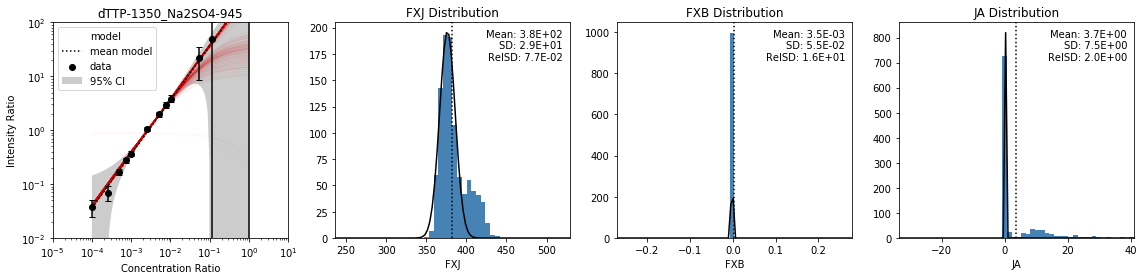


     end of plot_quantmodel_summary() function
    RMSPE: 1.3E-01

end of model training section!


/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log10


In [7]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = False

# define function to use when combining multiple intensity keys to get I1 or I2
combo_function = np.sum     # recommended: np.sum

# threshold for reporting issues (as fraction of datapoints)
report_threshold = 0.1

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING QUANTITATIVE MODEL TRAINING...")
else:
    print("FITTING QUANTITATIVE MODEL TO TRAINING DATA...")
    
    # ==================================================
    # get intensity data for specified keys
    A_component, B_component = Evaluation_Components
    if Intensity_Method == 'Deconvolution':
        A_keys, B_keys = [[0], [0]] 
        print()
        print("getting peak intensities from deconvolution...")
    else:
        A_keys = Intensity_Keys[A_component][Intensity_Method]
        B_keys = Intensity_Keys[B_component][Intensity_Method]
        print()
        print("getting peak intensities from %s values" % Intensity_Method)
        print("    Peak 1 (%s) - %s" % (A_component, A_keys))
        print("    Peak 2 (%s) - %s" % (B_component, B_keys))
        
    title = '%s-%s_%s-%s' % (
        A_component, "-".join(["%0.f" % key for key in A_keys]),
        B_component, "-".join(["%0.f" % key for key in B_keys])
    )
    fig_dir = "%s%s/" % (Fig_dir, Mixture)
    print("    %s%s_bootstrapping.png" % (fig_dir, title))

    # get values for intensity 1
    I1 = [intensities[str(key)] for key in A_keys]
    I1 = combo_function(np.asarray(I1), axis=0)
    I1_title = "+".join([str(key) for key in A_keys])

    # get values for intensity 2
    I2 = [intensities[str(key)] for key in B_keys]
    I2 = combo_function(np.asarray(I2), axis=0)
    I2_title = "+".join([str(key) for key in B_keys])

    print()
    print("input intensity value arrays:", np.shape(I1), np.shape(I2))

    # convert to intensity ratio
    IR = I1 / I2
    print("    intensity ratio array:", np.shape(IR))
    print("        mean values:", np.nanmean(IR, axis=1))

    # get concentration ratios
    CR = np.asarray([data[ID].components[A_component]/data[ID].components[B_component] for ID in Spec_IDs], dtype=np.float64)
    
    if Bootstrap == True:
        # ==================================================
        # train the model N times on data from N bootstrap resamples
        model = bootstrap_intensity_fit_script(CR, IR, title=title, truths={},
                                        show_plot=show_plot, save_plot=save_plot, fig_dir=fig_dir, debug=True)
            
    else:
        # ==================================================
        # train the model once on single dataset
        model = intensity_fit_script(CR, IR, debug=True)
        
    CR_pred, CR_err = predict_concentration(model, np.nanmean(IR, axis=1), np.nanstd(IR, axis=1))
    RMSPE = np.sqrt(np.nanmean(np.log10(CR_pred / CR)**2))
    print("    RMSPE: %0.1E" % RMSPE)

    print()
    print("end of model training section!")

PLOTTING QUANTITATIVE MODEL SUMMARY...
mean rel. uncertainty in IR: -3.4E-01

lower limits of detection:
    noise: 0.0E+00 +/- 0.0E+00
    model: 4.3E-04 +/- 1.2E-04

upper limits of detection:
    noise: INF +/- INF
    model: INF +/- INF

noise detect. range: inf orders mag.
model detect. range: inf orders mag.

lower limits of quantitation:
    noise: 0.0E+00 +/- 0.0E+00
    model: 1.4E-03 +/- 7.3E-05

upper limits of quantitation:
    noise: INF +/- INF
    model: INF +/- INF

noise quant. range: inf orders mag.
model quant. range: inf orders mag.


/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10


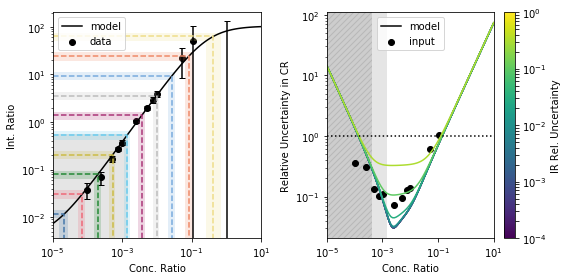

In [8]:
skip = False

debug = False

if skip == True:
    print("SKIPPING QUANTITATIVE MODEL PLOTTING...")
else:
    print("PLOTTING QUANTITATIVE MODEL SUMMARY...")
    
    # ==================================================
    # generate summary figure
    
    # determine x, y axis limits for axes
    x = CR
    check = np.logical_and(x > 0, ~np.isnan(x))
    x_min, x_max = 10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check])))
    x_curve = np.logspace(np.log10(x_min), np.log10(x_max), 100)
    y = intensity_curve(model, x_curve)
    check = np.logical_and(y > 0, ~np.isnan(y))
    y_min, y_max = 10**np.log10(0.5*np.nanmin(y[check])), 10**np.log10(2*np.nanmax(y[check]))
    
    print("mean rel. uncertainty in IR: %0.1E" % (np.mean(np.nanstd(IR, axis=1) / np.nanmean(IR, axis=1))))
    
    print()
    print("lower limits of detection:")
    LLOD = detection_limit(model, threshold=3., limit='lower', return_separate_values=True, debug=debug)
    for key in ['noise', 'model']:
        print("    %s: %0.1E +/- %0.1E" % (key, LLOD[key], LLOD[key+"_err"]))
    
    print()
    print("upper limits of detection:") 
    ULOD = detection_limit(model, threshold=3., limit='upper', return_separate_values=True, debug=debug)
    for key in ['noise', 'model']:
        print("    %s: %0.1E +/- %0.1E" % (key, ULOD[key], ULOD[key+"_err"]))
        
    print()
    print("noise detect. range: %0.1f orders mag." % (np.log10(ULOD['noise'])-np.log10(LLOD['noise'])))
    print("model detect. range: %0.1f orders mag." % (np.log10(ULOD['model'])-np.log10(LLOD['model'])))
    
    print()
    print("lower limits of quantitation:")  
    LLOQ = detection_limit(model, threshold=10., limit='lower', return_separate_values=True, debug=debug)
    for key in ['noise', 'model']:
        print("    %s: %0.1E +/- %0.1E" % (key, LLOQ[key], LLOQ[key+"_err"]))
        
    print()
    print("upper limits of quantitation:")
    ULOQ = detection_limit(model, threshold=10., limit='upper', return_separate_values=True, debug=debug)
    for key in ['noise', 'model']:
        print("    %s: %0.1E +/- %0.1E" % (key, ULOQ[key], ULOQ[key+"_err"]))
        
        
    print()
    print("noise quant. range: %0.1f orders mag." % (np.log10(ULOQ['noise'])-np.log10(LLOQ['noise'])))
    print("model quant. range: %0.1f orders mag." % (np.log10(ULOQ['model'])-np.log10(LLOQ['model'])))
    
    # start figure
    plt.figure(figsize=(8,4))
    
    # ax1: int. ratio vs conc. ratio
    ax = plt.subplot(121)
    # plot data
    x = CR
    y = np.nanmean(IR, axis=1)
    y_err = np.nanstd(IR, axis=1)
    ax.errorbar(x, y, yerr=y_err, fmt='none', c='k', capsize=3)
    ax.scatter(x, y, c='k', label='data')
    # plot mean model curve
    x_curve = np.logspace(np.log10(x_min), np.log10(x_max), 100)
    y_curve = intensity_curve(model, x_curve)
    ax.plot(x_curve, y_curve, 'k', label='model')
    
    # plot asymptotes
    ax.axhline(model['FXB'].value, c='k', linestyle=':')
    ax.axhline(model['FXJ_JA'].value, c='k', linestyle=':')
    
    # plot limits of quantitation
    if LLOQ['model'] > 0 and np.isinf(LLOQ['model']) == False:
        ax.fill(
            [x_min, x_min, LLOQ['model'], LLOQ['model']],
            [y_min, intensity_curve(model, LLOQ['model']), intensity_curve(model, LLOQ['model']), y_min],
            color='k', alpha=0.1, linewidth=0.
        )
    if ULOQ['model'] > 0 and np.isinf(ULOQ['model']) == False:
        ax.fill(
            [x_min, x_min, x_max, x_max, ULOQ['model'], ULOQ['model']],
            [intensity_curve(model, ULOQ['model']), y_max, y_max, y_min, y_min, intensity_curve(model, ULOQ['model'])],
            color='k', alpha=0.1, linewidth=0.
        )
    
    # plot test ranges
    IR_tests = np.logspace(np.log10(np.nanmin(y_curve)), np.log10(np.nanmax(y_curve)), 21)[1:-1:2]
    for IR_test, colour in zip(IR_tests, Colour_List):
        IR_err = 0.2 *IR_test
        IR_test_low, IR_test_high = IR_test - IR_err, IR_test + IR_err
        CR_pred, CR_err = predict_concentration(model, IR_test, IR_err)
        CR_pred_low, CR_low_err = predict_concentration(model, IR_test_low, 0.)
        CR_pred_high, CR_high_err = predict_concentration(model, IR_test_high, 0.)

        ax.plot([x_min, CR_pred, CR_pred], [IR_test, IR_test, y_min], colour, linestyle='--')
        ax.fill(
            [x_min, x_min, CR_pred_high, CR_pred_high, CR_pred_low, CR_pred_low],
            [IR_test_low, IR_test_high, IR_test_high, y_min, y_min, IR_test_low],
            color=colour, alpha=0.2, linewidth=0.
        )
        ### ax.axvspan(CR_pred_low, CR_pred_high, color=colour, alpha=0.2, linewidth=0.)
        if debug == True:
            print()
            print("input IR: %0.1E +/- %0.1E (%3.2f%%)" % (IR_test, IR_err, 100.*IR_err/IR_test))
            print("   range: %0.1E - %0.1E" % (IR_test_low, IR_test_high))
            print("pred CR: %0.1E +/- %0.1E (%3.2f%%)" % (CR_pred, CR_err, 100.*CR_err/CR_pred))
            print("   error range:  %0.1E - %0.1E" % (CR_pred-CR_err, CR_pred+CR_err))
            print("   actual range: %0.1E - %0.1E" % (CR_pred_low, CR_pred_high))
        
    # finish ax
    ax.set_xlabel("Conc. Ratio")
    ax.set_xlim(x_min, x_max)
    ax.set_xscale('log')
    ax.set_ylabel("Int. Ratio")
    ax.set_ylim(y_min, y_max)
    ax.set_yscale('log')
    ax.legend(loc='upper left')
    ax.minorticks_on()
    
    # ax2: relative uncertainties
    ax = plt.subplot(122)
    
    # plot rel. uncert. of training IR data
    ax.scatter(CR, np.nanstd(IR, axis=1) / np.nanmean(IR, axis=1), c='k', label='input')
    
    # plot rel. uncert. of CR prediction
    factors = [0.0001, 0.00032, 0.001, 0.0032, 0.01, 0.032, 0.1, 0.32]
    norm = mpl.colors.LogNorm(vmin=10**np.floor(np.nanmin(np.log10(factors))), vmax=10**np.ceil(np.nanmax(np.log10(factors))))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
    cmap.set_array([])
    CR_test = np.logspace(np.log10(x_min), np.log10(x_max), 100)
    IR_test = intensity_curve(model, CR_test)
    CR_pred, CR_pred_err = predict_concentration(model, IR_test, np.zeros_like(IR_test))
    ax.plot(CR_test, CR_pred_err/CR_pred, c='k', label='model')
    for factor in factors:
        IR_err = factor * IR_test
        CR_pred, CR_pred_err = predict_concentration(model, IR_test, IR_err)
        ax.plot(CR_test, CR_pred_err/CR_pred, c=cmap.to_rgba(factor))
        
    # plot failure line
    ax.axhline(1., linestyle=':', c='k')
    
    # plot limits of detection
    if LLOD['model'] > 0:
        ax.axvspan(x_min, LLOD['model'], color='k', hatch='////', linewidth=0., alpha=0.1)
    if ULOD['model'] > 0:
        ax.axvspan(ULOD['model'], x_max, color='k', hatch='////', linewidth=0., alpha=0.1)
        
    # plot limits of detection
    if LLOQ['model'] > 0:
        ax.axvspan(x_min, LLOQ['model'], color='k', linewidth=0., alpha=0.1)
    if ULOQ['model'] > 0:
        ax.axvspan(ULOQ['model'], x_max, color='k', linewidth=0., alpha=0.1)
    
    # finish ax
    ax.set_xlabel("Conc. Ratio")
    ax.set_xlim(x_min, x_max)
    ax.set_xscale('log')
    ax.set_ylabel("Relative Uncertainty in CR")
    ax.set_yscale('log')
    ax.legend(loc='upper center')
    plt.colorbar(cmap, ax=ax, label="IR Rel. Uncertainty")
    
    # finish figure
    plt.tight_layout()
    plt.savefig("%s%s/%s_%s-v-%s_uncertainties.png" % (Fig_dir, Mixture, Mixture, I1_title, I2_title), dpi=300)
    plt.show()

## This section fits each pair of peaks with its own model

In [9]:
# skip this section?
skip = True

# print debug messages in viewer?
debug = True

# specify which components to use as A and B

# define function to use when combining multiple intensity keys to get I1 or I2
combo_function = np.sum     # recommended: np.sum

# threshold for reporting issues (as fraction of datapoints)
report_threshold = 0.1

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING QUANTITATIVE MODEL TRAINING...")
else:
    print("FITTING QUANTITATIVE MODEL TO TRAINING DATA...")

    key_pairs = combinations(Components, 2)
    all_models = {}

    # iterate over all possible pairs of components
    for key_pair in key_pairs:
        # ==================================================
        # get intensity data for this pair of keys
        A_component, B_component = key_pair
        title = "%s-%s" % (A_component, B_component)
        if Intensity_Method == 'Deconvolution':
            A_keys, B_keys = [[0], [0]] 
            print()
            print("getting peak intensities from deconvolution...")
        else:
            A_keys = Intensity_Keys[A_component][Intensity_Method]
            B_keys = Intensity_Keys[B_component][Intensity_Method]
            print()
            print("getting peak intensities from %s values" % Intensity_Method)
            print("    Peak 1 (%s) - %s" % (A_component, A_keys))
            print("    Peak 2 (%s) - %s" % (B_component, B_keys))


        # get values for intensity 1
        I1 = [intensities[str(key)] for key in A_keys]
        I1 = combo_function(np.asarray(I1), axis=0)
        I1_title = "+".join([str(key) for key in A_keys])

        # get values for intensity 2
        I2 = [intensities[str(key)] for key in B_keys]
        I2 = combo_function(np.asarray(I2), axis=0)
        I2_title = "+".join([str(key) for key in B_keys])

        print()
        print("input intensity value arrays:", np.shape(I1), np.shape(I2))

        # convert to intensity ratio
        IR = I1 / I2
        print("    intensity ratio array:", np.shape(IR))

        # get concentration ratios
        CR = np.asarray([data[ID].components[A_component]/data[ID].components[B_component] for ID in Spec_IDs], dtype=np.float64)

        if Bootstrap == True:
            # ==================================================
            # train the model N times on data from N bootstrap resamples

            # prepare bootstrap results storage array
            bootstrap_results = {key: np.zeros(N_Bootstraps, dtype=np.float64) for key in ['FXJ', 'FXB', 'JA', 'FXJ_JA']}

            print()
            print("proceeding with bootstrap modelling, N = %d" % N_Bootstraps)
            count = 0
            for i in range(N_Bootstraps):
                # ==================================================
                # for each bootstrap sample

                # fit model to intensity curve
                fit_output = intensity_fit_script(CR, IR[:,i], J=1000, F=1., X=1., vary_FX=True, log=True,
                            report_threshold=0.1, title=title, fig_dir=Fig_dir, show_plot=False, debug=False)

                # add fitted parameter values to storage array
                for prop in ['FXJ', 'FXB', 'JA']:
                    bootstrap_results[prop][i] = fit_output[prop].value
                bootstrap_results['FXJ_JA'][i] = fit_output['FXJ'].value / fit_output['JA'].value

                if 10.*(i+1) / N_Bootstraps >= count + 1:
                    count += 1
                    print("%s/%s (%3.f%%) models fitted" % (i+1, N_Bootstraps, 10*count))

            # get mean parameter values and estimate errors
            model = lmfit.Parameters()
            for prop in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
                model.add(prop, value=np.nanmean(bootstrap_results[prop]))
                model[prop].stderr = np.nanstd(bootstrap_results[prop])
                model[prop].relerr = np.nanstd(bootstrap_results[prop])/np.nanmean(bootstrap_results[prop])

                # report results for each parameter
                print()
                print("%s:" % prop)
                print("           mean: %0.1E" % model[prop].value)
                print("         median: %0.1E" % np.median(bootstrap_results[prop]))
                print("          stdev: %0.1E (%3.3f%%)" % (model[prop].stderr, 100*model[prop].relerr))
                print("  min-max range: %0.1E - %0.1E" % (np.nanmin(bootstrap_results[prop]), np.nanmax(bootstrap_results[prop])))

            # calculate correlation coefficients
            corr = np.corrcoef([value for key, value in bootstrap_results.items()])

            # plot summary figures for bootstrapping, if required
            if show_plot == True or save_plot == True:
                # set up CR range for plotting predicted intensity curves
                x_temp = np.logspace(np.log10(np.amin(CR)), np.log10(np.amax(CR)), 100)

                # determine alpha (transparency) for data
                alpha = float(N_Bootstraps)**-0.75

                # ==================================================
                # set up single-row figure to plot individual parameter distributions
                fig, axs = plt.subplots(1, 4, figsize=(16,4))

                # first ax: intensity curves
                neg_check = np.concatenate(IR) > 0
                ax = axs.flat[0]
                ax.set_title(Mixture+"\n%s v %s" % (I1_title, I2_title))
                ax.set_xlabel("%s/%s CR" % (A_component, B_component))
                ax.set_ylabel("%s/%s Int" % (I1_title, I2_title))

                # add input data with errorbars
                ax.errorbar(CR, np.mean(IR, axis=1), yerr=np.std(IR, axis=1), fmt='none', ecolor='k', capsize=3, zorder=6)
                ax.scatter(CR, np.mean(IR, axis=1), c='k', label='mean', zorder=5)
                x_min = 10**np.floor(np.log10(0.9*np.nanmin(CR)))
                x_max = 10**np.ceil(np.log10(1.1*np.nanmax(CR)))
                ax.set_xscale('log')
                ax.set_xlim(x_min, x_max)
                y_min = 10**np.floor(np.log10(0.9*np.nanmin(np.concatenate(IR)[neg_check])))
                y_max = 10**np.ceil(np.log10(1.1*np.nanmax(np.concatenate(IR)[neg_check])))
                ax.set_yscale('log')
                ax.set_ylim(y_min, y_max)

                # add each bootstrap model curve as faint red line
                for i in range(N_Bootstraps):
                    curve = intensity_curve({key: value[i] for key, value in bootstrap_results.items()}, x_temp, debug=False)
                    label = '_subsample curve'
                    if i == 0:
                        label = label[1:]
                    ax.plot(x_temp, curve, c='r', label=label, alpha=alpha, zorder=3, linewidth=0.5)
                ax.legend()

                # plot each parameter distribution in its own ax
                for ax, prop in zip(axs.flat[1:], ['FXJ', 'FXB', 'JA']):
                    ax.set_title("%s Distribution" % prop)
                    ax.set_xlabel(prop)
                    x_min = model[prop].value - 5 * model[prop].stderr
                    x_max = model[prop].value + 5 * model[prop].stderr
                    ax.set_xlim(x_min, x_max)
                    hist, bins, patches = ax.hist(bootstrap_results[prop], range=(x_min, x_max), bins=50, color='steelblue')

                    text = [
                        "Mean: %0.1E" % model[prop].value,
                        "StErr: %0.1E" % model[prop].stderr,
                        "RelErr: %0.1E" % model[prop].relerr
                    ]

                    # fit distribution with normal distribution
                    params = lmfit.Parameters()
                    params.add('gradient', value=0., vary=False)
                    params.add('intercept', value=0., vary=False)
                    params.add('center_%s' % 0, value=model[prop].value)
                    params.add('amplitude_%s' % 0, value=np.nanmax(hist))
                    params.add('sigma_%s' % 0, value=model[prop].stderr)
                    fit = lmfit.minimize(multiG_fit, params, args=((bins[:-1]+bins[1:])/2, hist, [0]))
                    # plot normal distribution
                    temp = np.linspace(x_min, x_max, 5*len(bins))
                    curve = multiG_curve(fit.params, temp, [0])
                    ax.plot(temp, curve, 'k')
                    ax.text(x_min+0.35*(x_max-x_min), np.amax(hist)-0.11*(np.amax(hist)-np.amin(hist)), "\n".join(text), ha='right')

                plt.tight_layout()
                if save_plot == True:
                    plt.savefig("%s%s/%s_%s-v-%s_bootstrapping.png" % (Fig_dir, Mixture, Mixture,
                                        "+".join([str(key) for key in A_keys]),
                                        "+".join([str(key) for key in B_keys])),
                                dpi=300)
                if show_plot == True:
                    plt.show()
                else:
                    plt.close()

                # ==================================================
                # set up grid figure for parameter covariance
                plt.figure(figsize=(9,9))

                # plot input data
                ax = plt.subplot2grid((3,3), (0,2))
                ax.set_title("Intensity Spreads")
                ax.set_xlabel("CR")
                ax.set_ylabel("IR")
                ax.errorbar(CR, np.mean(IR, axis=1), yerr=np.std(IR, axis=1), fmt='none', ecolor='k', capsize=3, zorder=6)
                ax.scatter(CR, np.mean(IR, axis=1), c='k', label='mean', linewidth=0.5, zorder=5)
                x_min = 10**np.floor(np.log10(0.9*np.nanmin(CR)))
                x_max = 10**np.ceil(np.log10(1.1*np.nanmax(CR)))
                ax.set_xscale('log')
                ax.set_xlim(x_min, x_max)
                y_min = 10**np.floor(np.log10(0.9*np.nanmin(np.concatenate(IR)[neg_check])))
                y_max = 10**np.ceil(np.log10(1.1*np.nanmax(np.concatenate(IR)[neg_check])))
                ax.set_yscale('log')
                ax.set_ylim(y_min, y_max)

                # plot fitted curves
                for i in range(N_Bootstraps):
                    curve = intensity_curve({key: value[i] for key, value in bootstrap_results.items()}, x_temp, debug=False)
                    label = '_subsample curve'
                    if i == 0:
                        label = label[1:]
                    ax.plot(x_temp, curve, c='r', label=label, alpha=alpha, zorder=3)
                ax.legend()

                # plot each combination of parameters
                pairs = combinations_with_replacement(range(3), 2)
                for pair in pairs:
                    xi, yi = pair
                    x_prop = ['FXJ', 'FXB', 'JA'][xi]
                    y_prop = ['FXJ', 'FXB', 'JA'][yi]
                    # determine limits for axes
                    x_prop_min = np.nanmin(bootstrap_results[x_prop])
                    x_prop_max = np.nanmax(bootstrap_results[x_prop])
                    y_prop_min = np.nanmin(bootstrap_results[y_prop])
                    y_prop_max = np.nanmax(bootstrap_results[y_prop])
                    x_min = x_prop_min - 0.1*(x_prop_max - x_prop_min)
                    x_max = x_prop_max + 0.1*(x_prop_max - x_prop_min)
                    y_min = y_prop_min - 0.1*(y_prop_max - y_prop_min)
                    y_max = y_prop_min + 0.1*(y_prop_max - y_prop_min)
                    # create subplot for this prop pair
                    plt.subplot2grid((3,3), (yi, xi))
                    if x_prop == y_prop:
                        # plot single parameter as 1D histogram
                        plt.title(x_prop)
                        hist, bins, patches = plt.hist(bootstrap_results[x_prop], range=(x_min, x_max), bins=40, color='steelblue')
                        plt.xlim(x_min, x_max)
                        # fit distribution with normal distribution
                        params = lmfit.Parameters()
                        params.add('gradient', value=0., vary=False)
                        params.add('intercept', value=0., vary=False)
                        params.add('center_%s' % 0, value=model[x_prop].value)
                        params.add('amplitude_%s' % 0, value=np.nanmax(hist))
                        params.add('sigma_%s' % 0, value=model[x_prop].stderr)
                        fit = lmfit.minimize(multiG_fit, params, args=((bins[:-1]+bins[1:])/2, hist, [0]))
                        # plot normal distribution
                        x_temp = np.linspace(x_min, x_max, 5*len(bins))
                        curve = multiG_curve(fit.params, x_temp, [0])
                        plt.plot(x_temp, curve, 'r')
                        plt.axvline(model[x_prop].value, c='r', linestyle=':')
                    else:
                        # plot 2 parameters as 2D scatter
                        plt.title("%s v %s" % (y_prop, x_prop))
                        plt.scatter(bootstrap_results[x_prop], bootstrap_results[y_prop], c='steelblue', linewidth=0.,
                                    alpha=float(N_Bootstraps)**-0.25)
                        plt.axvline(model[x_prop].value, c='r', linestyle=':')
                        plt.axhline(model[y_prop].value, c='r', linestyle=':')
                        plt.xlim(x_min, x_max)
                        plt.ylim(y_min, y_max)
                        plt.text(x_min+0.1*(x_max-x_min), y_max-0.2*(y_max-y_min), "%0.1E" % corr[xi,yi], ha='left')
                    if xi == 0 and yi > 0:
                        plt.ylabel(y_prop)
                    if yi == 2:
                        plt.xlabel(x_prop)
                plt.tight_layout()
                if save_plot == True:
                    plt.savefig("%s%s/%s_%s-v-%s_bootstrapping_2D.png" % (Fig_dir, Mixture, Mixture,
                                        "+".join([str(key) for key in A_keys]),
                                        "+".join([str(key) for key in B_keys])),
                                dpi=300)
                if show_plot == True:
                    plt.show()
                else:
                    plt.close()

        else:
            # ==================================================
            # train the model once, on a single dataset

            # get intensity data
            temp = {key: intensities[key] for key in intensity_keys}

            # fit model to intensity curve
            fit_output = intensity_fit_script(CR, temp, plot=False, debug=debug,
                                    report_threshold=report_threshold, title=title, fig_dir=Fig_dir)

            # get fitted parameters
            model = fit_output.params

            # report results of fit
            for prop in ['FXJ', 'FXB', 'JA', 'FXJ_JA']:
                print()
                print("%s: %0.1E" % (prop, model[prop].value))

        # add final model to storage array
        all_models["%s/%s" % (A_component, B_component)] = model


    # ==================================================
    # now plot results of all models against intensities

    if show_plot == True or save_plot == True:
        # ==================================================
        # create figure
        size = 3
        width = size*len(Evaluation_Components)
        height = size*len(Evaluation_Components)
        plt.figure(figsize=(width, height))

        # create subplots for spectra
        if 'H2O' in Components:
            hydration = True
            third_width = int(np.ceil(width/3))
            print("%sx%s: %s -> %s x %s" % (height, width, 'spectra', 0, 0))
            print("%sx%s: %s -> %s x %s" % (height, width, 'hydration', 0, width-third_width))
            ax1 = plt.subplot2grid((height, width), (0,0), colspan=width-third_width, rowspan=size)
            ax2 = plt.subplot2grid((height, width), (0,width-third_width), colspan=third_width, rowspan=size)
        else:
            hydration = False
            ax1 = plt.subplot2grid((height, width), (0,0), colspan=width)
        ax1.set_xlim(x_start, x_end)
        ax1.set_ylim(-0.1, 1.1)
        ax1.minorticks_on()
        if hydration == True:
            ax2.set_xlim(2800, 3600)
            ax2.set_ylim(-0.1, 1.1)
            ax2.minorticks_on()
        for peak in peaks:
            if x_start < peak and peak < x_end:
                ax1.axvline(peak, color='k', linestyle=':')
            if hydration == True:
                if 2800 < peak and peak < 3600:
                    ax2.axvline(peak, color='k', linestyle=':')

        # generate colour map
        cmap_yesno = False
        if colour_by in ['conc_ratio']:
            # generate colour map based on sample/measurement property
            temp = np.asarray([getattr(data[ID], colour_by, np.nan) for ID in Spec_IDs])
            if colour_norm == 'log':
                check = np.logical_and(~np.isnan(temp), temp > 0)
                norm = mpl.colors.LogNorm(vmin=10**np.floor(np.log10(np.nanmin(temp[check]))),
                                              vmax=10**np.ceil(np.log10(np.nanmax(temp[check]))))
            else:
                norm = mpl.colors.Normalize(vmin=np.nanmin(temp), vmax=np.nanmax(temp))
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
            cmap.set_array([])
            plot_colours = cmap.to_rgba(temp)
            if hydration == True:
                plt.colorbar(cmap, ax=ax2, label=colour_by)
            else:
                plt.colorbar(cmap, ax=ax1, label=colour_by)
        elif len(Spec_IDs) < 10:
            # give each spectrum its own colour
            plot_colours = [Colour_List[i % len(Colour_List)] for i in range(len(Spec_IDs))]
        else:
            # too many spectra to plot, use group colour for all
            plot_colours = np.full(len(Spec_IDs), Colour_List[0])

        # plot spectra
        for i, ID in enumerate(Spec_IDs):
            x, y = get_plot_data(data[ID], x_key, y_key+"_av", start=x_start, end=x_end,
                        normalise=True, debug=debug)
            if len(Spec_IDs) < 10:
                # plot individual spectra as distinct lines with their own labels
                ax1.plot(x, y, c=plot_colours[i], label="%s" % (ID))
            else:
                # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                ax1.plot(x, y, c=plot_colours[i])

            if hydration == True:
                # get data for hydration range
                x, y = get_plot_data(data[ID], x_key, y_key+"_av", start=2800, end=4000,
                            normalise=True, debug=debug)
                # plot spectra
                if len(Spec_IDs) < 10:
                    # plot individual spectra as distinct lines with their own labels
                    ax2.plot(x, y, c=plot_colours[i], label="%s" % (ID))
                else:
                    # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                    ax2.plot(x, y, c=plot_colours[i])

        # determine x and y limits
        check = np.logical_and(~np.isnan(CR), CR > 0)
        x_min = 10**(np.floor(np.log10(0.9*np.nanmin(CR[check]))))
        x_max = 10**(np.ceil(np.log10(1.1*np.nanmax(CR[check]))))
        temp = []
        pairs = combinations(range(len(Evaluation_Components)), 2)
        for pair in pairs:
            xi, yi = pair
            A_component = Evaluation_Components[xi]
            B_component = Evaluation_Components[yi]
            title = "%s-%s" % (A_component, B_component)
            if Intensity_Method == 'Deconvolution':
                A_keys, B_keys = [[0], [0]] 
            else:
                A_keys = Intensity_Keys[A_component][Intensity_Method]
                B_keys = Intensity_Keys[B_component][Intensity_Method]
            # get values for intensities 1 and 2
            I1 = [intensities[str(key)] for key in A_keys]
            I1 = combo_function(np.asarray(I1), axis=0)
            if I1.ndim > 1:
                I1 = np.mean(I1, axis=1)
            I1_title = "+".join([str(key) for key in A_keys])
            I2 = [intensities[str(key)] for key in B_keys]
            I2 = combo_function(np.asarray(I2), axis=0)
            if I2.ndim > 1:
                I2 = np.mean(I2, axis=1)
            temp.append(I1 / I2)
        temp = np.ravel(temp)
        print(np.shape(temp))
        check = np.logical_and(~np.isnan(temp), temp > 0)
        y_min = 10**(np.floor(np.log10(0.9*np.nanmin(temp[check]))))
        y_max = 10**(np.ceil(np.log10(1.1*np.nanmax(temp[check]))))

        # =====
        # iterate over all possible pairs of components

        pairs = combinations(range(len(Evaluation_Components)), 2)

        for pair in pairs:
            # get intensity data for this pair of keys
            xi, yi = pair
            A_component = Evaluation_Components[xi]
            B_component = Evaluation_Components[yi]
            title = "%s-%s" % (A_component, B_component)

            if Intensity_Method == 'Deconvolution':
                A_keys, B_keys = [[0], [0]] 
                print()
                print("getting peak intensities from deconvolution...")
            else:
                A_keys = Intensity_Keys[A_component][Intensity_Method]
                B_keys = Intensity_Keys[B_component][Intensity_Method]
                print()
                print("getting peak intensities from %s values" % Intensity_Method)
                print("    Peak 1 (%s) - %s" % (A_component, A_keys))
                print("    Peak 2 (%s) - %s" % (B_component, B_keys))

            # get values for intensity 1
            I1 = [intensities[str(key)] for key in A_keys]
            I1 = combo_function(np.asarray(I1), axis=0)
            if I1.ndim > 1:
                I1_err = np.std(I1, axis=1)
                I1 = np.mean(I1, axis=1)
            else:
                I1_err = np.zeros_like(I1)
            I1_title = "+".join([str(key) for key in A_keys])

            # get values for intensity 2
            I2 = [intensities[str(key)] for key in B_keys]
            I2 = combo_function(np.asarray(I2), axis=0)
            if I2.ndim > 1:
                I2_err = np.std(I2, axis=1)
                I2 = np.mean(I2, axis=1)
            else:
                I2_err = np.zeros_like(I2)
            I2_title = "+".join([str(key) for key in B_keys])

            # plot intensity ratios
            print("%sx%s: %s x %s -> %s x %s" % (height, width, xi, yi, height-size*(1+xi), width-size*yi))
            plt.subplot2grid((height, width), (height-size*(1+xi), width-size*yi), colspan=size, rowspan=size)
            plt.title("%s/%s" % (A_component, B_component))

            # get mean intensities and errors for each sample
            IR = I1 / I2
            IR_err = IR * np.sqrt((I1_err/I1)**2 + (I2_err/I2)**2)

            # plot intensity ratio vs concentration ratio as scatter
            plt.scatter(CR, IR, c='k')
            plt.xlim(x_min, x_max)
            plt.xscale('log')
            plt.ylim(y_min, y_max)
            plt.yscale('log')
            if yi == fig_size-1:
                plt.ylabel("IR")
            if xi == 0:
                plt.xlabel("%s/%s CR" % (Components[0], Components[1]))

            # plot fitted model curve
            x_curve = np.logspace(np.log10(x_min), np.log10(x_max), 100)
            print(np.nanmin(x_curve), np.nanmax(x_curve))
            y_curve = intensity_curve(all_models["%s/%s" % (A_component, B_component)], x_curve, debug=False)
            print(np.nanmin(y_curve), np.nanmax(y_curve))
            plt.plot(x_curve, y_curve, 'k:', label='model')

        plt.tight_layout()
        if save_plot == True:
            plt.savefig("%s%s/%s_all-models.png" % (Fig_dir, Mixture, Mixture), dpi=300)
        if show_plot == True:
            plt.show()
        else:
            plt.close()

    print()
    print("end of model training section!")

SKIPPING QUANTITATIVE MODEL TRAINING...


## This section does leave-one-out cross-validated model training

FITTING QUANTITATIVE MODEL TO TRAINING DATA...

doing leave-one-out cross-validation...
    data points to test: 12

evaluating dTTP/Na2SO4 as A/B

getting peak intensities from Raw values
    Peak 1 (dTTP) - [1350]
    Peak 2 (Na2SO4) - [945]

input intensity value arrays: (12, 25) (12, 25)
       intensity ratio array: (12, 25)
   concentration ratio array: (12,)


training model on data minus point 0 (CR = 1.0E-04)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000


/Users/joby/Documents/JPL Archive/Quantitative Raman/OSTRI_functions.py:3246: RuntimeWarning: divide by zero encountered in double_scalars
  bootstrap_results['FXJ_JA'][i] = fit_output['FXJ'].value / fit_output['JA'].value


     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 2.7E+01 (7.127%)
       min-max range: 2.6E-10 - 4.4E+02

     FXB:
                mean: 3.5E-03
              median: 6.6E-15
               stdev: 6.4E-02 (1850.115%)
       min-max range: 0.0E+00 - 1.3E+00

     JA:
                mean: 3.2E+00
              median: 4.3E-12
               stdev: 6.7E+00 (210.373%)
       min-max range: 0.0E+00 - 4.2E+01

     FXJ_JA:
                mean: INF
              median: 8.7E+13
               stdev: NAN (nan%)
       min-max range: 1.6E-10 - INF

    using model to predict training CRs:
        In-sam

/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in log10
/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in log10


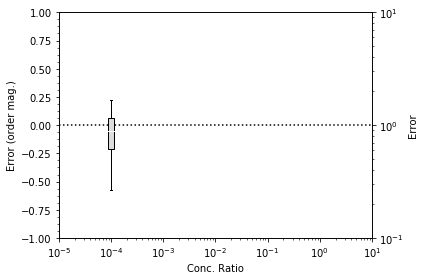



training model on data minus point 1 (CR = 2.5E-04)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 4.0E+02
              median: 3.9E+02
               stdev: 2.3E+01 (5.742%)
       min-max range: 1.2E-10 - 4.6E+02

     FXB:
                mean: 1.4E-03
              median: 1.4E-14
               stdev: 3.8E-02 (2785.950%)
       min-max range: 0.0E+00 - 1.2E+00

     JA:
                mean: 3.4E+00
              m

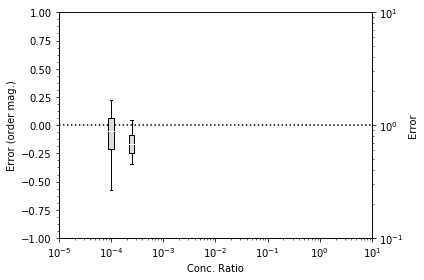



training model on data minus point 2 (CR = 5.0E-04)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.9E+02
              median: 3.8E+02
               stdev: 2.5E+01 (6.421%)
       min-max range: 4.7E-11 - 4.5E+02

     FXB:
                mean: 2.2E-03
              median: 6.2E-15
               stdev: 5.0E-02 (2222.949%)
       min-max range: 0.0E+00 - 1.1E+00

     JA:
                mean: 3.3E+00
              m

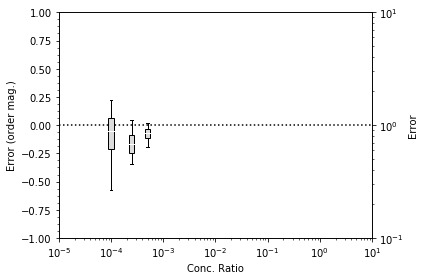



training model on data minus point 3 (CR = 7.5E-04)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 2.1E+01 (5.534%)
       min-max range: 4.2E-10 - 4.4E+02

     FXB:
                mean: 1.1E-03
              median: 6.4E-15
               stdev: 3.3E-02 (3128.977%)
       min-max range: 0.0E+00 - 1.1E+00

     JA:
                mean: 3.2E+00
              m

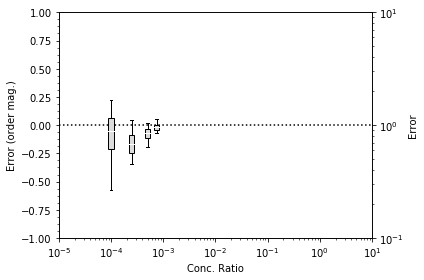



training model on data minus point 4 (CR = 1.0E-03)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 2.1E+01 (5.527%)
       min-max range: 6.4E-10 - 4.4E+02

     FXB:
                mean: 1.0E-03
              median: 7.1E-15
               stdev: 3.3E-02 (3128.836%)
       min-max range: 0.0E+00 - 1.0E+00

     JA:
                mean: 3.2E+00
              m

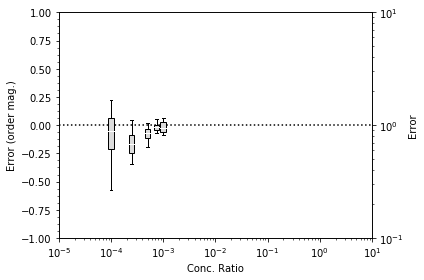



training model on data minus point 5 (CR = 2.5E-03)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 1.7E+01 (4.391%)
       min-max range: 3.5E+02 - 4.3E+02

     FXB:
                mean: 2.3E-05
              median: 8.9E-15
               stdev: 2.2E-04 (936.882%)
       min-max range: 0.0E+00 - 3.5E-03

     JA:
                mean: 3.1E+00
              me

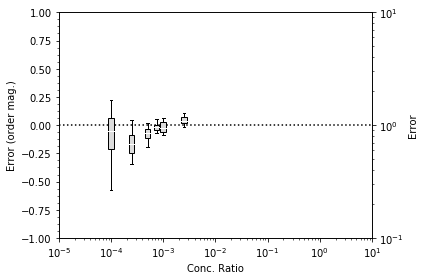



training model on data minus point 6 (CR = 5.0E-03)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 1.6E+01 (4.239%)
       min-max range: 3.5E+02 - 4.3E+02

     FXB:
                mean: 1.6E-05
              median: 7.8E-15
               stdev: 1.7E-04 (1067.482%)
       min-max range: 0.0E+00 - 3.1E-03

     JA:
                mean: 3.1E+00
              m

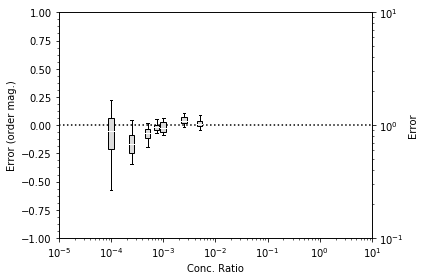



training model on data minus point 7 (CR = 7.6E-03)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 2.6E+01 (6.860%)
       min-max range: 9.3E-12 - 4.3E+02

     FXB:
                mean: 2.2E-03
              median: 7.8E-15
               stdev: 4.1E-02 (1842.623%)
       min-max range: 0.0E+00 - 8.5E-01

     JA:
                mean: 3.1E+00
              m

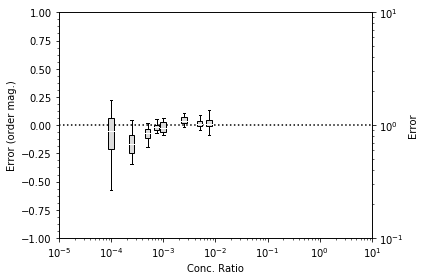



training model on data minus point 8 (CR = 1.0E-02)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 2.6E+01 (6.798%)
       min-max range: 8.5E-11 - 4.3E+02

     FXB:
                mean: 2.2E-03
              median: 7.3E-15
               stdev: 4.0E-02 (1844.906%)
       min-max range: 0.0E+00 - 8.2E-01

     JA:
                mean: 3.1E+00
              m

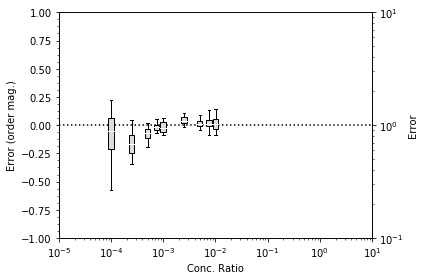



training model on data minus point 9 (CR = 5.3E-02)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 3.2E+01 (8.513%)
       min-max range: 3.2E-14 - 4.4E+02

     FXB:
                mean: 2.8E-03
              median: 9.4E-15
               stdev: 3.6E-02 (1281.973%)
       min-max range: 0.0E+00 - 4.8E-01

     JA:
                mean: 3.9E+00
              m

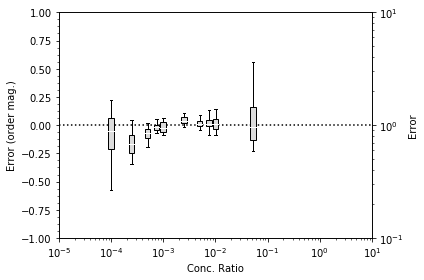



training model on data minus point 10 (CR = 1.1E-01)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.7E+02
              median: 3.7E+02
               stdev: 3.7E+01 (9.946%)
       min-max range: 2.6E-12 - 4.6E+02

     FXB:
                mean: 4.9E-03
              median: 9.8E-15
               stdev: 5.5E-02 (1120.261%)
       min-max range: 0.0E+00 - 6.8E-01

     JA:
                mean: 5.5E+00
              

/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


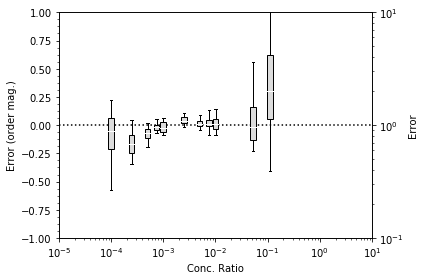



training model on data minus point 11 (CR = 1.0E+00)
    training dataset: (11,) (11, 25)
     testing dataset: () (25,)

     bootstrapping input data, N = 1000
          input data array: (11, 25)
         output data array: (11, 1000)

     proceeding with bootstrap modelling, N = 1000
     100/1000 ( 10%) models fitted
     200/1000 ( 20%) models fitted
     300/1000 ( 30%) models fitted
     400/1000 ( 40%) models fitted
     500/1000 ( 50%) models fitted
     600/1000 ( 60%) models fitted
     700/1000 ( 70%) models fitted
     800/1000 ( 80%) models fitted
     900/1000 ( 90%) models fitted
     1000/1000 (100%) models fitted

     FXJ:
                mean: 3.8E+02
              median: 3.8E+02
               stdev: 8.3E+00 (2.213%)
       min-max range: 3.5E+02 - 4.0E+02

     FXB:
                mean: 9.4E-06
              median: 9.3E-15
               stdev: 1.1E-04 (1115.610%)
       min-max range: 0.0E+00 - 2.1E-03

     JA:
                mean: 6.4E-02
              

/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in log10
/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: Mean of empty slice
/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:179: RuntimeWarning: invalid value encountered in log10


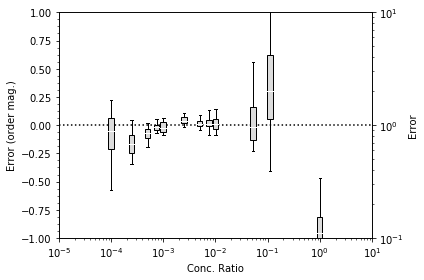

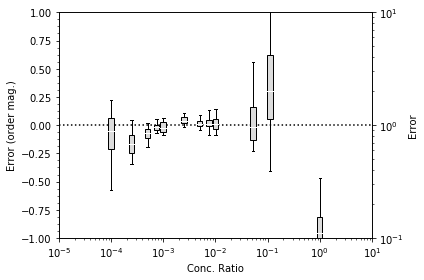


CROSS-VALIDATION DONE


In [10]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = True

# define function to use when combining multiple intensity keys to get I1 or I2
combo_function = np.sum     # recommended: np.sum

# threshold for reporting issues (as fraction of datapoints)
report_threshold = 0.1

# show plots in viewer?
show_plot = False

# save plots to file?
save_plot = False

# 
test_indices = range(len(data.keys()))

cv_results = {
    'model': [],
    'FXJ': [],
    'FXB': [],
    'JA': [],
    'FXJ_JA': [],
    'train_truth': [],
    'train_pred_av': [],
    'train_pred_std': [],
    'train_pred_relstd': [],
    'train_pred_err': [],
    'train_RMSPE': [],
    'test_truth': [],
    'test_pred': [],
    'test_pred_av': [],
    'test_pred_std': [],
    'test_pred_relstd': [],
    'test_pred_err': [],
    'test_RMSPE': []
}


if skip == True:
    print("SKIPPING QUANTITATIVE MODEL TRAINING...")
else:
    print("FITTING QUANTITATIVE MODEL TO TRAINING DATA...")
    
    print()
    print("doing leave-one-out cross-validation...")
    print("    data points to test:", len(test_indices))
    
    # ==================================================
    # get intensity data for specified keys
    print()
    print("evaluating %s as A/B" % "/".join(Evaluation_Components))
    A_component, B_component = Evaluation_Components
    if Intensity_Method == 'Deconvolution':
        A_keys, B_keys = [[0], [0]] 
        print()
        print("getting peak intensities from deconvolution...")
    else:
        A_keys = Intensity_Keys[A_component][Intensity_Method]
        B_keys = Intensity_Keys[B_component][Intensity_Method]
        print()
        print("getting peak intensities from %s values" % Intensity_Method)
        print("    Peak 1 (%s) - %s" % (A_component, A_keys))
        print("    Peak 2 (%s) - %s" % (B_component, B_keys))
    
    # get values for intensity 1
    I1 = [intensities[str(key)] for key in A_keys]
    I1 = combo_function(np.asarray(I1), axis=0)
    I1_title = "+".join([str(key) for key in A_keys])
    
    # get values for intensity 2
    I2 = [intensities[str(key)] for key in B_keys]
    I2 = combo_function(np.asarray(I2), axis=0)
    I2_title = "+".join([str(key) for key in B_keys])
    
    print()
    print("input intensity value arrays:", np.shape(I1), np.shape(I2))
    
    # convert to intensity ratio
    IR = I1 / I2
    print("       intensity ratio array:", np.shape(IR))
    
    # get concentration ratios
    CR = np.asarray([data[ID].components[A_component] / data[ID].components[B_component] for ID in Spec_IDs])
    print("   concentration ratio array:", np.shape(CR))
    
    for ti in test_indices:
        # ==================================================
        # for each data point, remove it from dataset and train model
        print()
        print()
        print("training model on data minus point %s (CR = %0.1E)" % (ti, CR[ti]))
        
        # generate training dataset (minus current datapoint)
        CR_train = np.delete(CR, ti, axis=0)
        IR_train = np.delete(IR, ti, axis=0)
        
        print("    training dataset:", np.shape(CR_train), np.shape(IR_train))
        
        # generate testing dataset (current datapoint only)
        CR_test = CR[ti]
        IR_test = IR[ti]
        
        print("     testing dataset:", np.shape(CR_test), np.shape(IR_test))
        
        if Bootstrap == True:
            # ==================================================
            # train the model N times on data from N bootstrap resamples
            model = bootstrap_intensity_fit_script(CR_train, IR_train, title=title, truths={},
                                            show_plot=show_plot, save_plot=save_plot, fig_dir=fig_dir, tabs=1, debug=True)

        else:
            # ==================================================
            # train the model once on single dataset
            model = intensity_fit_script(CR_train, IR_train, tabs=1, debug=True)
            
        # add trained model to results dict
        cv_results['model'].append(model)
        for prop in ['FXJ', 'FXB', 'JA']:
            cv_results[prop].append(model[prop].mean)
            
        # ==================================================
        # test the model on training data
        
        if IR_train.ndim > 1:
            IR_train_av = np.nanmean(IR_train, axis=1)
            IR_train_std = np.nanstd(IR_train, axis=1)
        else:
            IR_train_av = np.nanmean(IR_train)
            IR_train_std = np.nanstd(IR_train)
        CR_train_pred_av, CR_train_pred_std = predict_concentration(model, IR_train_av, IR_train_std)
        RMSPE_train = np.sqrt(np.nanmean(np.log10(CR_train_pred_av / CR_train)**2))
        
        cv_results['train_truth'].append(CR_train)
        cv_results['train_pred_av'].append(CR_train_pred_av)
        cv_results['train_pred_std'].append(CR_train_pred_std)
        cv_results['train_pred_relstd'].append(CR_train_pred_std / CR_train_pred_av)
        cv_results['train_pred_err'].append(np.log10(CR_train_pred_av / CR_train))
        cv_results['train_RMSPE'].append(RMSPE_train)
        
        print()
        print("    using model to predict training CRs:")
        print("        In-sample (train) RMSPE: %0.1E" % RMSPE_train)
        
        # ==================================================
        # test the model on testing data
        
        if IR_test.ndim > 1:
            IR_test_av = np.nanmean(IR_test, axis=1)
            IR_test_std = np.nanstd(IR_test, axis=1)
        else:
            IR_test_av = np.nanmean(IR_test)
            IR_test_std = np.nanstd(IR_test)
        
        CR_test_pred, CR_test_pred_std = predict_concentration(model, IR_test)
        neg_check = CR_test_pred <= 0
        print(np.shape(CR_test_pred), "non-positives:", np.count_nonzero(neg_check))
        CR_test_pred_av, CR_test_pred_std = predict_concentration(model, IR_test_av, IR_test_std)
        RMSPE_test = np.sqrt(np.nanmean(np.log10(CR_test_pred_av / CR_test)**2))
            
        cv_results['test_truth'].append(CR_test)
        cv_results['test_pred'].append(CR_test_pred[~neg_check])
        cv_results['test_pred_av'].append(CR_test_pred_av)
        cv_results['test_pred_std'].append(CR_test_pred_std)
        cv_results['test_pred_relstd'].append(CR_test_pred_std / CR_test_pred_av)
        cv_results['test_pred_err'].append(np.log10(CR_test_pred[~neg_check] / CR_test))
        cv_results['test_RMSPE'].append(RMSPE_test)
        
        print()
        print("    using model to predict testing CRs:")
        print("                 true CR: %0.1E" % CR_test)
        print("       mean predicted CR: %0.1E +/- %0.1E" % (CR_test_pred_av, CR_test_pred_std))
        print("          pred. CR range: %0.1E - %0.1E" % (np.nanmin(CR_test_pred[~neg_check]), np.nanmax(CR_test_pred[~neg_check])))
        print("               neg check: %0.f/%0.f" % (np.count_nonzero(CR_test_pred <= 0), np.size(CR_test_pred)))
        print("             pred. error: %0.1f orders mag." % np.log10(CR_test_pred_av/CR_test))
        print("        Out-sample (test) RMSPE:  %0.1E" % RMSPE_test)
        
        
        print()
        print("cross-validation %s/%s done" % (ti+1, len(data.keys())))
        print()
        
        # plot errors as boxplot
        plt.figure(figsize=(6,4))
        ax = plt.subplot(111)
        ax.set_xlabel("Conc. Ratio")
        ax.set_ylabel("Error (order mag.)")
        ax2 = ax.twinx()
        ax2.set_ylabel("Error")
        
        print(np.shape(cv_results['test_truth']), np.shape(cv_results['test_pred_err']))

        # plot spread of predicted concentrations from individual intensities
        width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
        ax.boxplot(cv_results['test_pred_err'], positions=cv_results['test_truth'],
                   widths=width(cv_results['test_truth'],0.1), patch_artist=True, showfliers=False,
                   medianprops={'color': 'w'},
                   boxprops={'facecolor': 'gainsboro'},
                   flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
                  )
        
        ax.set_xlim(x_min, x_max)
        ax.set_xscale('log')
        ax.set_ylim(-1, 1)
        ax2.set_ylim(10**-1, 10**1)
        ax2.set_yscale('log')
        ax.axhline(0., c='k', linestyle=':')
        ax.minorticks_on()
        plt.tight_layout()
        plt.show()
        
    # plot errors as boxplot
    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)
    ax.set_xlabel("Conc. Ratio")
    ax.set_ylabel("Error (order mag.)")
    ax2 = ax.twinx()
    ax2.set_ylabel("Error")
    
    # plot spread of predicted concentrations from individual intensities
    width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
    ax.boxplot(cv_results['test_pred_err'], positions=cv_results['test_truth'],
               widths=width(cv_results['test_truth'],0.1), patch_artist=True, showfliers=False,
               medianprops={'color': 'w'},
               boxprops={'facecolor': 'gainsboro'},
               flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
              )
        
    for key in cv_results.keys():
        cv_results[key] = np.asarray(cv_results[key])
        
    # determine x, y axis limits for axes
    x = CR
    check = np.logical_and(x > 0, ~np.isnan(x))
    x_min, x_max = 10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check])))
    x_curve = np.logspace(np.log10(x_min), np.log10(x_max), 100)
    y = np.concatenate(cv_results['test_pred_err'])
    check = np.logical_and(y > 0, ~np.isnan(y))
    y_min, y_max = 10**np.log10(0.5*np.nanmin(y[check])), 10**np.log10(2*np.nanmax(y[check]))
    
    ax.set_xlim(x_min, x_max)
    ax.set_xscale('log')
    ax.set_ylim(-1, 1)
    ax2.set_ylim(10**-1, 10**1)
    ax2.set_yscale('log')
    ax.axhline(0., c='k', linestyle=':')
    ax.minorticks_on()
    plt.tight_layout()
    plt.savefig("%s%s/%s_%s-v-%s_CV-errors.png" % (Fig_dir, Mixture, Mixture, I1_title, I2_title), dpi=300)
    plt.show()
    
    headers = ['Test CR', 'Pred. CR', 'Rel. Pred. Uncertainty', 'FXJ', 'FXB', 'JA', 'Train RMSPE', 'Test RMSPE']
    keys = ['test_truth', 'test_pred_av', 'test_pred_relstd', 'FXJ', 'FXB', 'JA', 'train_RMSPE', 'test_RMSPE']
    save_data = [cv_results[key] for key in keys]
    save_data = pd.DataFrame(np.vstack(save_data).transpose(), columns=headers)
    save_data.to_csv("%s%s/%s_%s-v-%s_CV-results.csv" % (Fig_dir, Mixture, Mixture, I1_title, I2_title), float_format='%0.1E')
    
    print()
    print("CROSS-VALIDATION DONE")